In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pickle as pickle

from skimage.measure import label, regionprops, perimeter

import math
import sys
#sys.path.append('../../util')
#from curvature import *


# Create Pickels

In [4]:
%%capture
for TTT in np.arange(295,306):
    #Read Data
    path = '/project/s916/davidle/RCE-MIP/simulations/RCE_'+str(TTT)+'_3km_506x506/' #Path for Daint
    d2D = xr.open_mfdataset(path+'output/lfff????0000.nc', combine='by_coords', )

    with open('pickles/output_'+str(TTT)+'.pkl', 'wb') as pickle_file:
        pickle.dump(d2D, pickle_file)

# Plots snapshots of CVW

In [ ]:
%%capture
#Read Data
try:
    d2D = pickle.load( open('pickles/output_300.pkl', "rb" ) )
except:
    path = '/project/s916/davidle/RCE-MIP/simulations/RCE_300_3km_506x506/' #Path for Daint
    d2D = xr.open_mfdataset(path+'output/lfff????0000.nc', combine='by_coords', )

In [3]:
#Create a binary mask based on median(TQV). Separate into wet and dry regions
na = 48
bTQV = np.zeros(np.shape(d2D.TQV), dtype=bool)
for t in range(len(d2D.TQV[:])-na):
    fld = np.mean(d2D.TQV[t:t+na,:,:],axis=0) #Daily mean
    bTQV[t,:,:] = np.where(fld > np.percentile(fld, 88, interpolation='linear',  axis=(0,1))[np.newaxis, np.newaxis], 1, 0)

/users/davidle/venv-3.6/lib/python3.6/site-packages/skimage/measure/_regionprops.py:250: UserWarning: regionprops and image moments (including moments, normalized moments, central moments, and inertia tensor) of 2D images will change from xy coordinates to rc coordinates in version 0.16.
See https://scikit-image.org/docs/0.14.x/release_notes_and_installation.html#deprecations for details on how to avoid this message.
  warn(XY_TO_RC_DEPRECATION_MESSAGE)
/users/davidle/venv-3.6/lib/python3.6/site-packages/skimage/measure/_regionprops.py:260: UserWarning: regionprops and image moments (including moments, normalized moments, central moments, and inertia tensor) of 2D images will change from xy coordinates to rc coordinates in version 0.16.
See https://scikit-image.org/docs/0.14.x/release_notes_and_installation.html#deprecations for details on how to avoid this message.
  warn(XY_TO_RC_DEPRECATION_MESSAGE)


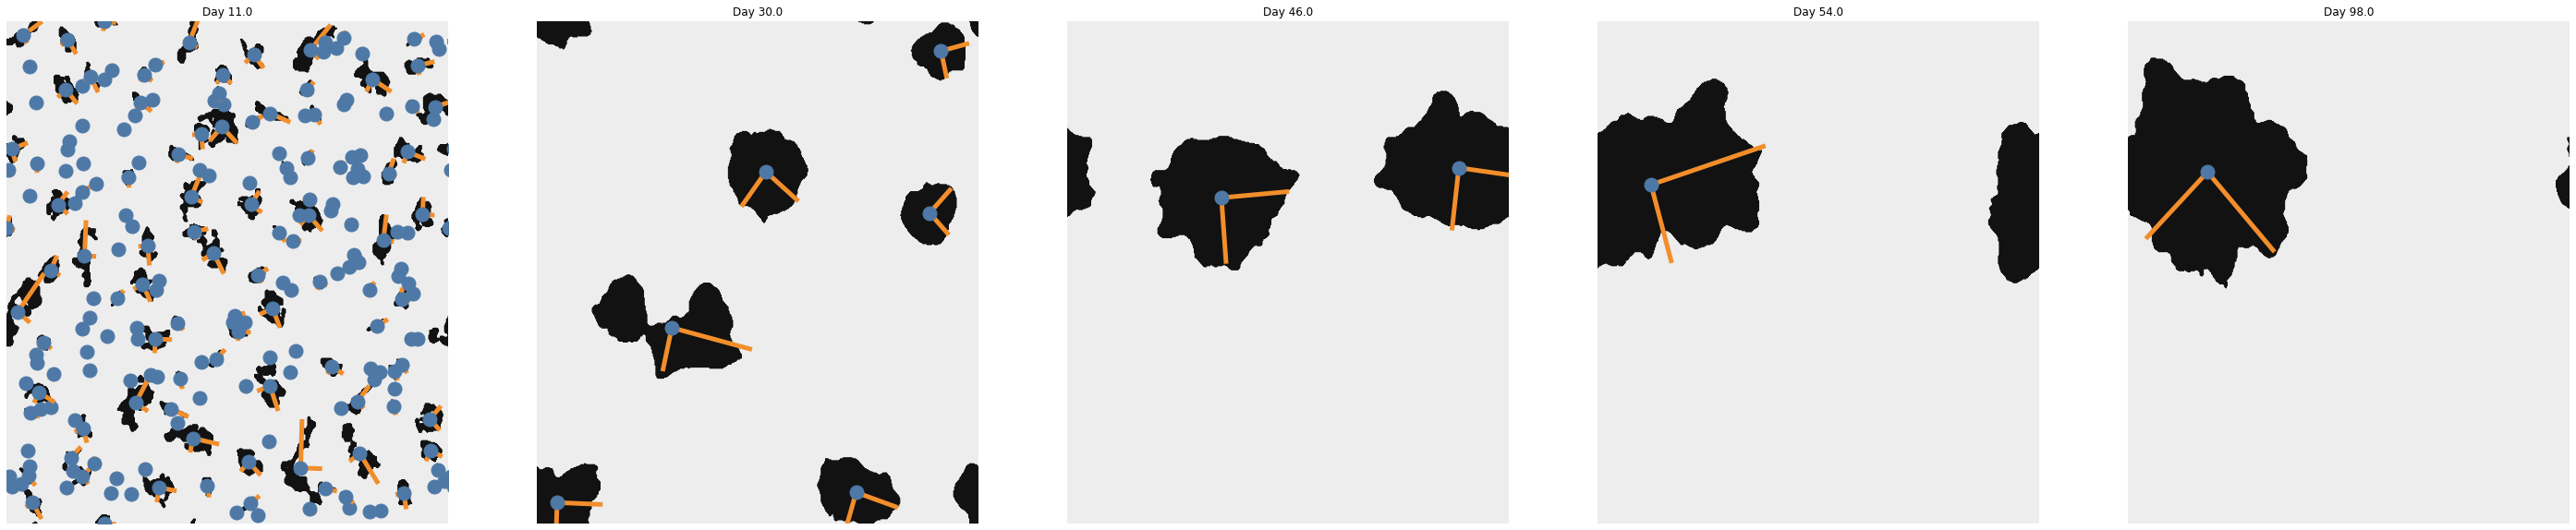

In [4]:
#Options
nb = 3  #Number of Boundary Points (e.g. nboundlines form the cosmo namelist)
nt, xn, yn = np.shape(bTQV)
na=2 #averaging period in days

#Domain of the analysis region in the tiled field
xl  = np.floor_divide(xn, 2)
xr  = np.floor(3/2 * xn).astype(int)

yl  = np.floor_divide(yn, 2)
yr  = np.floor(3/2 * yn).astype(int)

plt.figure(figsize=(60, 10))

nr = 1 #Counter for subplots
for t in np.array([11,30,46,54,100-na]) * 24 - 1:
    
    tiled_bTQV = np.flip(np.tile(bTQV[t,nb:-nb,nb:-nb],(2,2)))
    
    plt.subplot(1, 6, nr)
    nr += 1
    plt.contourf(tiled_bTQV[xl:xr,yl:yr], cmap = 'binary')
    plt.title('Day '+np.rint(t/24).astype('str'))

    labels = label(tiled_bTQV[:,:], neighbors=8)
    props = regionprops(labels)
    
    for p in range(len(props)):
        y0, x0 = props[p].centroid
        
         #Skip allobjects who's centroid is not in the untiled domain
        if  x0 < xl or x0 > xr:
            continue
        
        if  y0 < yl or y0 > yr:
            continue
                
        y0, x0 = props[p].centroid - xl
        x1 = x0 + math.cos(props[p].orientation) * 0.5 * props[p].major_axis_length
        y1 = y0 - math.sin(props[p].orientation) * 0.5 * props[p].major_axis_length
        x2 = x0 - math.sin(props[p].orientation) * 0.5 * props[p].minor_axis_length
        y2 = y0 - math.cos(props[p].orientation) * 0.5 * props[p].minor_axis_length

        plt.plot((x0, x1), (y0, y1), color='#F28E2B', linewidth=5)
        plt.plot((x0, x2), (y0, y2), color='#F28E2B', linewidth=5)
        plt.plot(x0, y0, marker='.', color='#4E79A7', markersize=30)
        
        plt.xlim((0,500))
        plt.ylim((0,500))
        plt.axis('off')

plt.savefig('blobs_88.pdf')

# Eccentricity

In [2]:
def eccentricity(fld, lobj = 1, nb = 3 ):
    #lobj: track the lobj largest objects
    #nb:   number of boundary lines of periodic domain
    
    nt,xn,yn = np.shape(fld)

    #Domain of the analysis region in the tiled field
    xl  = np.floor_divide(xn, 2)
    yl  = np.floor_divide(yn, 2)
    xr  = np.floor(3/2 * xn)
    yr  = np.floor(3/2 * yn)
    
    #Allocate arrays
    perim = np.empty(nt)
    a = np.empty(nt)
    b = np.empty(nt)
    nobj = np.empty(nt)
    
    for t in range(nt):
     
        #To take care of the periodic domain the domain is copied four times.
        tiled_fld = np.tile(fld[t,nb:-nb,nb:-nb],(2,2))

        labels = label(tiled_fld, neighbors=8)
        props = regionprops(labels)

        #Find the lobj biggest objects
        area = np.array([])
        ind = np.array([], dtype=int)
        for p in range(len(props)):
        
            y0, x0 = props[p].centroid - xl
        
            #Skip all objects who's centroid is not in the untiled domain
            if  x0 < xl or x0 > xr :
                continue
        
            if  y0 < yl+ nb or y0 > yr:
                continue

            area = np.append(area, props[p].area)
            ind = np.append(ind, p)
            

        le  = np.minimum(lobj, len(ind)) #When lobj is bigger than props (towards the end of simulation)
    
        for p in ind[np.argpartition(area, -le)[-le:]]:
            if np.isfinite(props[p].minor_axis_length): #If objects very small then b undefined
                a[t] += props[p].major_axis_length
                b[t] += props[p].minor_axis_length

        perim[t] = perimeter(tiled_fld, neighbourhood=8)  / 4
        nobj[t] = len(props)
        
    return perim, a, b, nobj

In [3]:
### Compute Eccentricity for all Temperatures
nt = 2400
na = 48 #averaging period in days
perc=88 #Probability variable
perim = np.zeros((nt-na,9), dtype='float32')
a = np.zeros((nt-na,9), dtype='float32')
b = np.zeros((nt-na,9), dtype='float32')
num = np.zeros((nt-na,9), dtype='float32')

for TTT in np.arange(296,305):
    print(TTT)
    try:
        perim[:,TTT-296]  = pickle.load( open( 'pickles/perim_'+str(TTT)+'.pkl', "rb" ) )
        a[:,TTT-296] = pickle.load( open( 'pickles/a_'+str(TTT)+'.pkl', "rb" ) )
        b[:,TTT-296] = pickle.load( open( 'pickles/b_'+str(TTT)+'.pkl', "rb" ) )
        num[:,TTT-296] = pickle.load( open( 'pickles/num_'+str(TTT)+'.pkl', "rb" ) )
    except:
        try:
            d2D = pickle.load( open( 'pickles/output_'+str(TTT)+'.pkl', "rb" ) )
        except:
            path = '/project/s916/davidle/RCE-MIP/simulations/RCE_'+str(TTT)+'_3km_506x506/' #Path for Daint
            d2D = xr.open_mfdataset(path+'output/lfff????0000.nc', combine='by_coords', )

        #Create a binary mask based on th. Separate into wet and dry regions
        bTQV = np.zeros((nt-na, 506, 506), dtype=bool)
        for t in range(nt - na):
            fld = np.mean(d2D.TQV[t:t+na,:,:],axis=0)
            bTQV[t,:,:] = np.where(fld > np.percentile(fld, perc, interpolation='linear',  axis=(0,1))[np.newaxis, np.newaxis], 1, 0)

        perim[:,TTT-296], a[:,TTT-296], b[:,TTT-296], num[:,TTT-296] = eccentricity(bTQV, lobj = 5)
            
        with open('pickles/perim_'+str(TTT)+'.pkl', 'wb') as pickle_file:
            pickle.dump(perim[:,TTT-296], pickle_file)
            
        with open('pickles/a_'+str(TTT)+'.pkl', 'wb') as pickle_file:
            pickle.dump(a[:,TTT-296], pickle_file)
            
        with open('pickles/b_'+str(TTT)+'.pkl', 'wb') as pickle_file:
            pickle.dump(b[:,TTT-296], pickle_file)
        
        with open('pickles/num_'+str(TTT)+'.pkl', 'wb') as pickle_file:
            pickle.dump(num[:,TTT-296], pickle_file)

296
297
298
299


/users/davidle/venv-3.6/lib/python3.6/site-packages/skimage/measure/_regionprops.py:250: UserWarning: regionprops and image moments (including moments, normalized moments, central moments, and inertia tensor) of 2D images will change from xy coordinates to rc coordinates in version 0.16.
See https://scikit-image.org/docs/0.14.x/release_notes_and_installation.html#deprecations for details on how to avoid this message.
  warn(XY_TO_RC_DEPRECATION_MESSAGE)
/users/davidle/venv-3.6/lib/python3.6/site-packages/skimage/measure/_regionprops.py:260: UserWarning: regionprops and image moments (including moments, normalized moments, central moments, and inertia tensor) of 2D images will change from xy coordinates to rc coordinates in version 0.16.
See https://scikit-image.org/docs/0.14.x/release_notes_and_installation.html#deprecations for details on how to avoid this message.
  warn(XY_TO_RC_DEPRECATION_MESSAGE)


300


/users/davidle/venv-3.6/lib/python3.6/site-packages/skimage/measure/_regionprops.py:250: UserWarning: regionprops and image moments (including moments, normalized moments, central moments, and inertia tensor) of 2D images will change from xy coordinates to rc coordinates in version 0.16.
See https://scikit-image.org/docs/0.14.x/release_notes_and_installation.html#deprecations for details on how to avoid this message.
  warn(XY_TO_RC_DEPRECATION_MESSAGE)
/users/davidle/venv-3.6/lib/python3.6/site-packages/skimage/measure/_regionprops.py:260: UserWarning: regionprops and image moments (including moments, normalized moments, central moments, and inertia tensor) of 2D images will change from xy coordinates to rc coordinates in version 0.16.
See https://scikit-image.org/docs/0.14.x/release_notes_and_installation.html#deprecations for details on how to avoid this message.
  warn(XY_TO_RC_DEPRECATION_MESSAGE)


301


/users/davidle/venv-3.6/lib/python3.6/site-packages/skimage/measure/_regionprops.py:250: UserWarning: regionprops and image moments (including moments, normalized moments, central moments, and inertia tensor) of 2D images will change from xy coordinates to rc coordinates in version 0.16.
See https://scikit-image.org/docs/0.14.x/release_notes_and_installation.html#deprecations for details on how to avoid this message.
  warn(XY_TO_RC_DEPRECATION_MESSAGE)
/users/davidle/venv-3.6/lib/python3.6/site-packages/skimage/measure/_regionprops.py:260: UserWarning: regionprops and image moments (including moments, normalized moments, central moments, and inertia tensor) of 2D images will change from xy coordinates to rc coordinates in version 0.16.
See https://scikit-image.org/docs/0.14.x/release_notes_and_installation.html#deprecations for details on how to avoid this message.
  warn(XY_TO_RC_DEPRECATION_MESSAGE)


302
303


/users/davidle/venv-3.6/lib/python3.6/site-packages/skimage/measure/_regionprops.py:250: UserWarning: regionprops and image moments (including moments, normalized moments, central moments, and inertia tensor) of 2D images will change from xy coordinates to rc coordinates in version 0.16.
See https://scikit-image.org/docs/0.14.x/release_notes_and_installation.html#deprecations for details on how to avoid this message.
  warn(XY_TO_RC_DEPRECATION_MESSAGE)
/users/davidle/venv-3.6/lib/python3.6/site-packages/skimage/measure/_regionprops.py:260: UserWarning: regionprops and image moments (including moments, normalized moments, central moments, and inertia tensor) of 2D images will change from xy coordinates to rc coordinates in version 0.16.
See https://scikit-image.org/docs/0.14.x/release_notes_and_installation.html#deprecations for details on how to avoid this message.
  warn(XY_TO_RC_DEPRECATION_MESSAGE)


304


/users/davidle/venv-3.6/lib/python3.6/site-packages/skimage/measure/_regionprops.py:250: UserWarning: regionprops and image moments (including moments, normalized moments, central moments, and inertia tensor) of 2D images will change from xy coordinates to rc coordinates in version 0.16.
See https://scikit-image.org/docs/0.14.x/release_notes_and_installation.html#deprecations for details on how to avoid this message.
  warn(XY_TO_RC_DEPRECATION_MESSAGE)
/users/davidle/venv-3.6/lib/python3.6/site-packages/skimage/measure/_regionprops.py:260: UserWarning: regionprops and image moments (including moments, normalized moments, central moments, and inertia tensor) of 2D images will change from xy coordinates to rc coordinates in version 0.16.
See https://scikit-image.org/docs/0.14.x/release_notes_and_installation.html#deprecations for details on how to avoid this message.
  warn(XY_TO_RC_DEPRECATION_MESSAGE)


/apps/daint/UES/jenkins/7.0.UP01/gpu/easybuild/software/jupyterlab/1.1.1-CrayGNU-19.10-batchspawner/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in subtract
  from ipykernel import kernelapp as app
/apps/daint/UES/jenkins/7.0.UP01/gpu/easybuild/software/jupyterlab/1.1.1-CrayGNU-19.10-batchspawner/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in add
  from ipykernel import kernelapp as app
/apps/daint/UES/jenkins/7.0.UP01/gpu/easybuild/software/jupyterlab/1.1.1-CrayGNU-19.10-batchspawner/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app
/apps/daint/UES/jenkins/7.0.UP01/gpu/easybuild/software/jupyterlab/1.1.1-CrayGNU-19.10-batchspawner/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in minimum
/apps/daint/UES/jenkins/7.0.UP01/gpu/easybuild/s

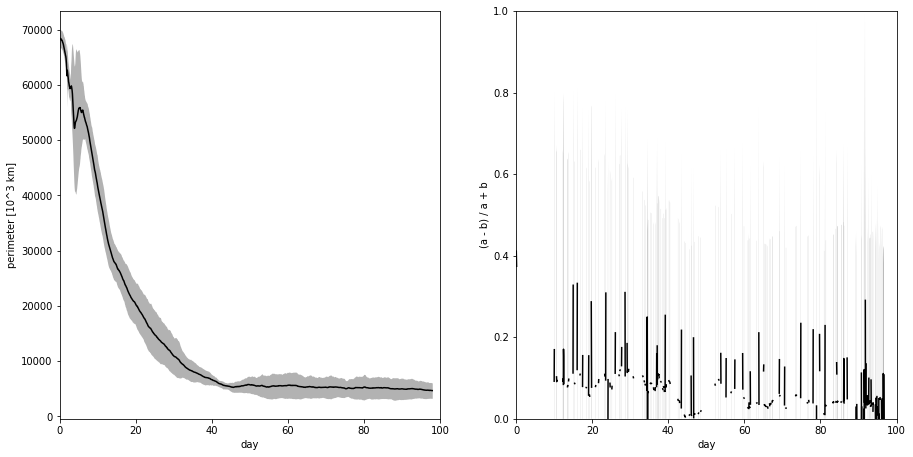

In [4]:
plt.figure(figsize=(15, 7.5))

plt.subplot(1,2,1)
dx= 3.3
plt.plot(np.arange(len(perim)) / 24 , np.mean(perim * dx,axis=1), color='k')
plt.fill_between(np.arange(len(perim)) / 24 , np.mean(perim*dx,axis=1) + np.std(perim*dx,axis=1), np.maximum(np.mean(perim*dx,axis=1) - np.std(perim*dx,axis=1),0), alpha=0.3, color='k', linewidth=0.0)
plt.ylabel('perimeter [10^3 km]')
plt.xlabel('day')

#plt.yscale('log')
#plt.ylim(12**3, 12**5)
plt.xlim((0,100))

plt.subplot(1,2,2)
ec =  (a-b)/(a+b) #Eccentricity
plt.plot(np.arange(len(a)) / 24, np.mean(ec, axis=1), color='k')
plt.fill_between(np.arange(len(ec)) / 24, np.minimum(np.mean(ec, axis=1) + np.std(ec, axis=1),1), np.maximum(np.mean(ec, axis=1) - np.std(ec, axis=1),0), alpha=0.3, color='k', linewidth=0.0)
plt.ylabel('(a - b) / a + b')
plt.xlabel('day')
plt.xlim((0,100))
plt.ylim((0,1))


plt.savefig('ellipsoid_88.pdf')


## MMLi 

In [2]:
def calc_MMLi(CRH, dx = 3.3e3, perc=88):
    ### Input:Column Water Vapour (x, y)
    ### Returns: aggregation index calculated as 4*area*pi/(perimeter length)**2
    ###          which compares the length of the boundary between the moist and 
    ###          the dry region with the circumference of the moist region
    ### Parameters: dx grid spacing of input field, perc 
    
    binary = np.where(CRH > np.percentile(CRH, perc, interpolation='linear',  axis=(0,1))[np.newaxis, np.newaxis], 1, 0)
    A_tot = np.sum(binary)*(dx**2) #Area equals to the number of grid points times the gridspacing
    
    WMI = 2*np.sqrt(np.pi*A_tot)/(dx*perimeter(binary))
    
    return WMI

In [3]:
na = 48 #averaging period in hours
nt = 2400
MMLi = np.zeros((nt-na,9), dtype='float32') #Moisture Meandering Index
iqr = np.zeros((nt-na,9), dtype='float32') #Interquartile range
iqr_95 = np.zeros((nt-na,9), dtype='float32') #Interquartile range

for TTT in np.arange(296,305):
    print(TTT)
    try:
        iqr[:,TTT-296] = pickle.load( open( 'pickles/iqr_'+str(TTT)+'.pkl', "rb" ) )
        MMLi[:,TTT-296] = pickle.load( open( 'pickles/MMLi_'+str(TTT)+'.pkl', "rb" ) )
    except:
        try:
            d2D = pickle.load( open( 'pickles/output_'+str(TTT)+'.pkl', "rb" ) )
        except:
            path = '/project/s916/davidle/RCE-MIP/simulations/RCE_'+str(TTT)+'_3km_506x506/' #Path for Daint
            d2D = xr.open_mfdataset(path+'output/lfff????0000.nc', combine='by_coords' )

        for t in range(nt-na):
            fld = d2D.TQV[t:t+na,:,:].mean(axis=0)
            iqr[t,TTT-296] = np.percentile(fld, 75, interpolation='linear',  axis=(0,1)) - np.percentile(fld, 25, interpolation='linear',  axis=(0,1))
            MMLi[t,TTT-296] = calc_MMLi(fld)

        #Save data
        with open('pickles/iqr_'+str(TTT)+'.pkl', 'wb') as pickle_file:
            pickle.dump(iqr[:,TTT-296], pickle_file)
        
        with open('pickles/MMLi_'+str(TTT)+'.pkl', 'wb') as pickle_file:
            pickle.dump(MMLi[:,TTT-296], pickle_file)

296
297
298
299
300
301
302
303
304


<Figure size 432x288 with 0 Axes>

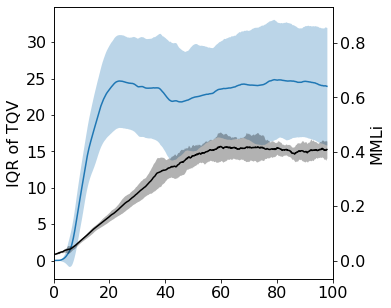

In [13]:
def align_yaxis(ax1, v1, ax2, v2):
    """adjust ax2 ylimit so that v2 in ax2 is aligned to v1 in ax1"""
    """source https://stackoverflow.com/questions/10481990/matplotlib-axis-with-two-scales-shared-origin """
    _, y1 = ax1.transData.transform((0, v1))
    _, y2 = ax2.transData.transform((0, v2))
    inv = ax2.transData.inverted()
    _, dy = inv.transform((0, 0)) - inv.transform((0, y1-y2))
    miny, maxy = ax2.get_ylim()
    ax2.set_ylim(miny+dy, maxy+dy)


plt.figure()

fig, ax1  = plt.subplots()
plt.xlim((0,100))
fig.set_figheight(5)
fig.set_figwidth(5)

ax1.set_ylabel('IQR of TQV') 
ax1.plot(np.arange(len(iqr)) / 24 , np.mean(iqr,axis=1), color='C0')
ax1.fill_between(np.arange(len(iqr)) / 24, np.mean(iqr, axis=1) + np.std(iqr, axis=1), np.mean(iqr, axis=1) - np.std(iqr, axis=1), alpha=0.3, color='C0', linewidth=0.0)


ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.plot(np.arange(len(MMLi)) / 24 , np.mean(MMLi,axis=1), color='k',)
ax2.fill_between(np.arange(len(MMLi)) / 24, np.mean(MMLi, axis=1) + np.std(MMLi, axis=1), np.mean(MMLi, axis=1) - np.std(MMLi, axis=1), alpha=0.3, color='k', linewidth=0.0)
ax2.set_ylabel('MMLi') 
ax2.set_ylim((0, 1))

align_yaxis(ax1, 0, ax2, 0)
 
plt.savefig('WMI_RCE_88.pdf')

### Humidity Distributions

In [7]:
def edgTObin(edges):
    return 0.5*(edges[1:]+edges[:-1])

In [10]:
%%capture

try:
    d2D_300 = pickle.load( open( 'pickles/output_300.pkl', "rb" ) )
except:
    path = '/project/s916/davidle/RCE-MIP/simulations/RCE_300_3km_506x506/' #Path for Daint
    d2D_300 = xr.open_mfdataset(path+'output/lfff????0000.nc', combine='by_coords')

try:
    d2D_304 = pickle.load( open( 'pickles/output_304.pkl', "rb" ) )
except:
    path = '/project/s916/davidle/RCE-MIP/simulations/RCE_304_3km_506x506/' #Path for Daint
    d2D_304 = xr.open_mfdataset(path+'output/lfff????0000.nc', combine='by_coords') 

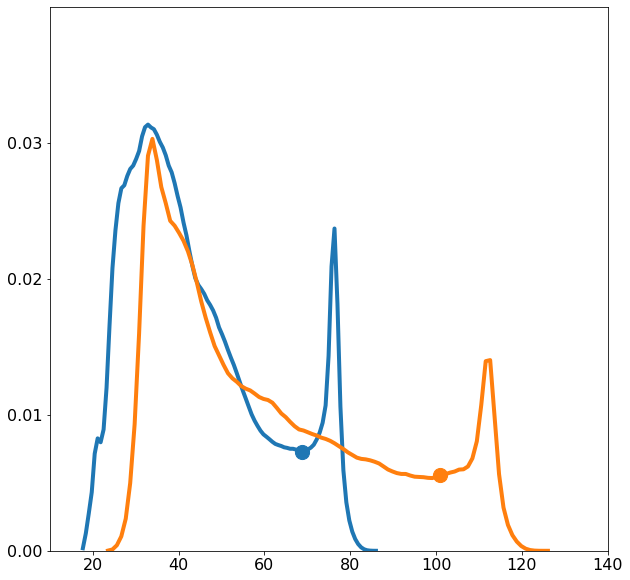

In [11]:
fig=plt.figure(figsize=(10,10))
plt.rcParams.update({'font.size': 16})

hist_300, edges_300 = np.histogram(d2D_300.TQV[24*85:,:,:], density = True, bins = 100)
histmax_300, edges  = np.histogram(d2D_300.TQV[24*85:,:,:].max(dim='time'), density = True, bins = 100)
histmin_300, edges  = np.histogram(d2D_300.TQV[24*85:,:,:].min(dim='time'), density = True, bins = 100)

plt.plot(edgTObin(edges_300), hist_300, label = '300', color = 'C0', linewidth=4)
plt.scatter(np.percentile(d2D_300.TQV[24*85:,:,:], 88),y=np.interp(x=np.percentile(d2D_300.TQV[24*85:,:,:], 88),xp=edgTObin(edges_300),fp=hist_300),color='C0',s=200)

hist_304, edges_304 = np.histogram(d2D_304.TQV[24*85:,:,:], density = True, bins = 100)
histmax_304, edges  = np.histogram(d2D_304.TQV[24*85:,:,:].max(dim='time'), density = True, bins = 100)
histmin_304, edges  = np.histogram(d2D_304.TQV[24*85:,:,:].min(dim='time'), density = True, bins = 100)

plt.plot(edgTObin(edges_304), hist_304, label = '304', color = 'C1', linewidth=4)
plt.scatter(np.percentile(d2D_304.TQV[24*85:,:,:], 88),y=np.interp(x=np.percentile(d2D_304.TQV[24*85:,:,:], 88),xp=edgTObin(edges_304),fp=hist_304),color='C1', s=200)

plt.xlim(10,140)
plt.ylim(0,0.04)
plt.yticks(np.arange(0, 0.04, step=0.01))

plt.savefig('WMI_RCE_Hist_88.pdf')

# Moisture Imbalance

In [4]:
d2D = pickle.load( open( 'pickles/output_300.pkl', "rb" ) )

In [23]:
#Latent heat of vaporization
lh_v = 2.501e6

In [26]:
P = d2D.TOT_PREC.isel(time=slice(60*24,None)).mean(axis=(1,2))
E = d2D.ALHFL_S.isel(time=slice(60*24,None)).mean(axis=(1,2)) / lh_v*3600
dPW_dt = np.gradient(d2D.TWATER.isel(time=slice(60*24,None)).mean(axis=(1,2))) * 3600 / 20

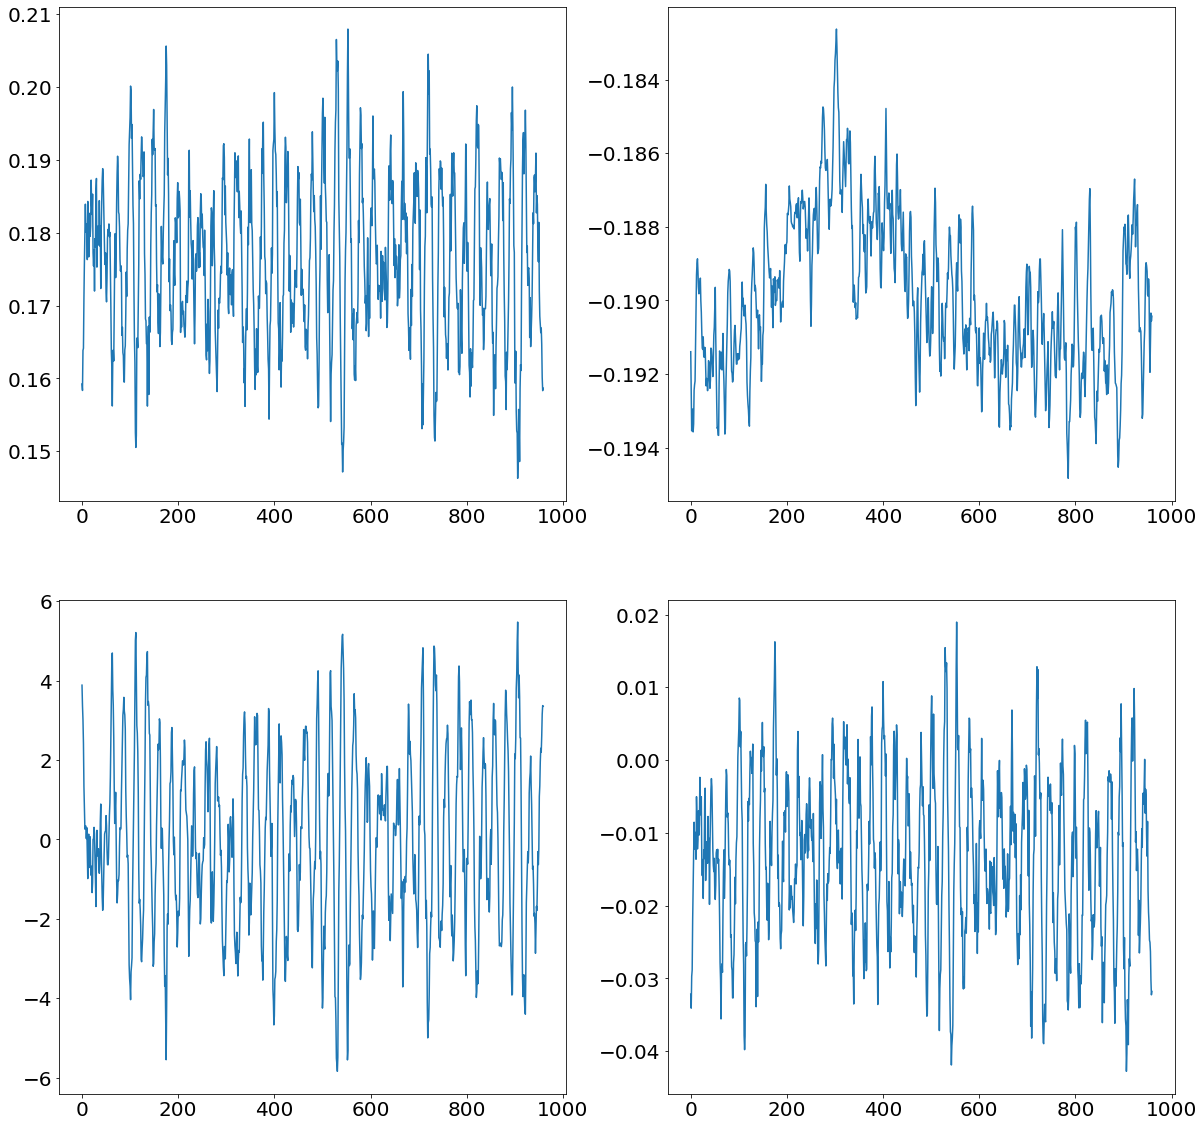

In [28]:
fig = plt.figure(figsize=(20, 20))
plt.rcParams.update({'font.size': 20})

plt.subplot(2,2,1)
plt.plot(P)


plt.subplot(2,2,2)
plt.plot(E)


plt.subplot(2,2,3)
plt.plot(dPW_dt)

plt.subplot(2,2,4)
plt.plot(P + E)

In [38]:
print(P.mean().values)
print(E.mean().values)
print(dPW_dt.mean())
print(P.mean().values + E.mean().values + dPW_dt.mean())

0.17643815
-0.18988304
0.016324997
0.0028801113


In [35]:
#Imbalance as related to the sensible heatflux
print((P.mean().values + E.mean().values + dPW_dt.mean()) / E.mean().values) * 100

-0.0151678175


In [ ]:
for TTT in np.arange(296,305):
    try:
            d2D = pickle.load( open( 'pickles/output_'+str(TTT)+'.pkl', "rb" ) )
        except:
            path = '/project/s916/davidle/RCE-MIP/simulations/RCE_'+str(TTT)+'_3km_506x506/' #Path for Daint
            d2D = xr.open_mfdataset(path+'output/lfff????0000.nc', combine='by_coords', )